# Rolling Regressions

## Imports

In [2]:
# <include-rolling_regressions/utils.py>

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# <imports>
import numpy as np
import pandas as pd
import plotly.io as pio
from patsy import dmatrices
import statsmodels.api as sm

from rolling_regressions import utils

pio.renderers.default = "notebook_connected"
pd.options.plotting.backend = "plotly"
pio.templates.default = "seaborn"

## Summary

In this assignment we calculate regression coefficients for daily returns of 210 individual equities versus the market derived from exponentially weighted and boxcar widows of various lengths and compare them to coefficients calculated from a forward boxcar window. Our basis for comparison is that the coefficients calculated from the forward boxcar windows are the "correct" coefficients and we therefore endeavor to determine which set of historical coefficients are most similar. To determine similarity we perform the following analyses across window methodology and length.

* Compare moments
* Compare histograms
* Compare correlations

Returns are calculated from daily adjusted closing prices for the period from 2016-01-01 to 2020-12-31 for 210 equities that meet the criteria from the quantile trading assignment. We establish weights for the exponentially weighted windows based on characteristic times of $\frac{1}{\lambda}$ ranging from 3 to 60 observations (our analysis makes the simplifying assumption that the duration between observations is the same). Historical boxcar windows lengths are calculated as $\frac{2}{\lambda}$ and range from 6 to 120 observations. In order to have one historical boxcar window length with the same length as the forward window, we set the length of the forward boxcar window at 6 observations instead of 5.

The context for most similar is that we are trying to establish coefficients upon which to base hedges with the experiment being that at each point the actual betas are those from the forward window and that we had put in place hedges based on the coefficients from the historical windows. To simulate this, we assume that we establish a long position of \\$10,000 equally weighted across each of the equities, calculate the average $\beta$, and then assume that we had established a position in the market equal to $-\beta \cdot \text{\$10,000}$. 

The subject data set for our analysis includes daily adjusted closing prices for the period from 2016-01-01 to 2020-12-31 for 210 equities that meet the criteria from the quantile trading assignment. We establish weights for the exponentially weighted windows based on characteristic times of $\frac{1}{\lambda}$ ranging from 3 to 60 observations (our analysis makes the simplifying assumption that the duration between observations is the same). Historical boxcar windows lengths are calculated as $\frac{2}{\lambda}$ and range from 6 to 120 observations. In order to have one historical boxcar window length with the same length as the forward window, we set the length of the forward boxcar window at 6 observations instead of 5.

To demonstrate the first main point of the assignment, we use the framework that the forward boxcar window coefficients are the "correct" ones and compare them to the coefficients calculated from the various 

A more macro approach to making the first point can be seen in asking the question, if we were trying to establish betas for purposes of hedging our portfolio of 200 equities, which which windowing method is best? Within the best windowing method, which duration is best across the entire portfolio? Are the different method and duration combinations that are better for certain subsets of the tickers in the portfolio? Do those tickers share any other obvious characteristics? Are the different periods of the entire duration for which different windowing method and duration combinations perform better?

## Analysis

### Load Prices

In [5]:
df_prices = pd.read_csv("df_prices.csv", usecols=["ticker", "date", "adj_close"]).set_index(["ticker", "date"])
excl_tickers = ["AMRC", "AT", "CCO"]
tickers = [s for s in df_prices.index.levels[0][:210].to_list() if s not in excl_tickers]
df_prices = df_prices.loc[tickers  + ["SPY"]].sort_index()
assert df_prices.isna().groupby("ticker").max().sum()[0] == 0

### Compare Weights

The chart below shows the normalized cumulative weight for each of the exponentially weighted window lengths through 120 days. The main point is that observations well past the time $t$ continue to impact the moving average. It general, observations greater than $t$ comprise approximately 35% of the statistics. Given a boxcar window length of $\frac{2}{\lambda}$ for 10 observations of 20, for example ($\lambda = 0.1)$, the equivalent exponentially weighted window affords approximately 13% of its weight to observations greater than 20.

In [6]:
win_lengths = np.array([3, 6, 10, 30, 60, 90])

In [7]:
nobs = 1440
fig = utils.go.Figure()
for w in win_lengths:
    weights = np.power(1 - 1/w, np.arange(nobs))
    weights = weights / weights.sum()
    fig.add_scatter(x=(np.arange(nobs) + 1)[:120], y=pd.Series(weights).cumsum().values, name=f"w = {w}")
fig.update_layout(title_text="Cumulative Weight by Window Length")
fig.show()

### Calculate Returns

In [8]:
df_ret = np.log(df_prices.adj_close.unstack("ticker") / df_prices.adj_close.unstack("ticker").shift())
df_ret

ticker,AAWW,ABM,ACIW,ACM,ADP,ADS,AEGN,AEP,AES,AGCO,...,KMB,KMI,KMX,KO,KR,KRA,KRO,KSS,KSU,SPY
date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,-0.010246,0.002346,-0.003392,-0.007058,0.002434,0.008575,-0.009484,0.008195,0.013692,0.014341,...,0.020348,0.020098,-0.004785,0.003531,0.022343,-0.030867,0.000000,0.004631,0.003521,0.001690
2016-01-06,-0.018507,-0.009842,-0.004866,-0.015636,-0.012353,-0.014222,-0.032825,0.003734,-0.035129,-0.009243,...,-0.000465,-0.053390,-0.075910,-0.005420,-0.000951,0.009981,-0.082997,0.005409,-0.047048,-0.012694
2016-01-07,-0.084317,-0.021474,-0.044895,-0.030258,-0.030995,-0.030629,-0.008791,-0.011586,-0.025234,0.000663,...,-0.016883,-0.035841,-0.025153,-0.016679,-0.023581,-0.038600,-0.041223,0.016054,-0.020180,-0.024284
2016-01-08,-0.019964,-0.005253,-0.021661,-0.018173,-0.008285,-0.019344,-0.072666,-0.001544,0.014341,-0.004207,...,-0.012932,0.035841,-0.006602,-0.002646,-0.006596,-0.012334,-0.038820,-0.060379,0.008063,-0.011037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.006971,-0.012910,0.013588,0.002263,0.007790,0.009768,0.017291,0.008758,-0.009410,-0.004254,...,0.002917,0.000000,-0.009489,0.006759,0.004450,0.024702,-0.000665,-0.020855,0.002557,0.003883
2020-12-28,-0.023611,0.019433,-0.008078,-0.009291,0.000283,0.006368,-0.002601,-0.001721,0.001288,-0.010030,...,0.000448,-0.013833,-0.014185,0.013383,-0.004450,-0.007677,0.001329,0.030873,0.006786,0.008554
2020-12-29,-0.015253,-0.019168,-0.009860,0.005791,-0.009901,-0.020493,-0.021053,-0.001231,0.000429,-0.009044,...,0.001343,-0.005145,0.013534,-0.000554,0.002228,-0.011441,-0.018091,-0.005999,-0.006486,-0.001910


Here is our familiar pattern of generally upward drift with a significant drop and increased volatility at the onset of the pandemic. It's interesting that the performance of this particular set of equities was so much worse than the market over this period.

In [9]:
utils.make_return_chart(df_ret)

### Calculate Betas

Here we calculate betas for each equity for each observation for each window type for each window length (1.3 million in total). We do this by using the rolling covariance matrix function in pandas to get the covariance versus SPY and the variance for each ticker and then calculate betas directly as $\hat{\beta} = \frac{\mathrm{Cov}(x,y)}{\mathrm{Var}(x)}$.

We do a quick check of the the mean $\hat{\beta}$ for the forward boxcar window to make sure data is available for each of our selected tickers.

In [10]:
df_betas = utils.get_betas(df_ret, win_lengths)
fig = df_betas.boxcar_fwd.beta_1.t_03.groupby("ticker").mean().plot(kind="bar", title="Mean Beta")
fig.update_layout(showlegend=False)
fig.show()

  0%|          | 0/6 [00:00<?, ?it/s]

### Compare Moments

This is a dense chart, but allows us to compare the betas for the various combinations of window type and window length from one chart with y_axes for each statistic on the same scale. The moments are across the columns and the rows by window type. Note that the window length for all of the length labels for the forward box car window is 6 observations to facilitate comparison with the other window methods at varying lengths.

* Variance decrease significantly with window length, as we would expect given the larger number of observations included in the longer windows.
* Mean beta decreases as window length increases as a result of covariance decreasing at a faster rate than the variance in the denominator (variance of equity and market decrease as window lenght increases, covariance in the numerator is akin to the product of the variances versus just the variance by itself in the denominator). What's interesting is that the mean beta actually starts to increase again for the window lengths greater than 30. I'm not sure why this would be since the variance is still decreasing.
* Kurtosis decreases with window length similarly to variance.
* By design, the statistics for the boxcar and forward boxcar windows of length 6 (t_03) are nearly identical (but for the lag of 6 days).
* For the shorter windows, the mean beta for the exponentially weighted windows is less than it is for the boxcar windows, likely related to the effectively greater number of observations included in the exponentially weighted windows and the relative impact on covariance versus variance.


In [11]:
df_moments = utils.get_moments(df_betas.loc["2016-02-01":])
fig = utils.make_moments_chart(df_moments)
fig.show()

### Compare Distributions

Here we plot distributions of coefficients for each window length. The range has been limited to betas of with an absolute value less than two in order to make differences in order to focus on differences in the core distributions, although there are outliers with absolute values greater than 8 in the t_03 window duration. Note again, that the forward boxcar window length is the same in each plot at 6 observations.

* We can see the reduction in variability and outliers as window length increases.
* If we were just trying to match the shapes of the distributions, the shortest window duration, which matches the duration of the forward boxcar window appears to be the most similar.
* It is interesting to note that the reduction in skewness as the window durations increase. Per the discussion in lecture, this would seem to be consistent with the idea that betas are in fact positive over the long run.
* We also see starting in the t_10 plot that the boxcar window appears to have more outliers in it.


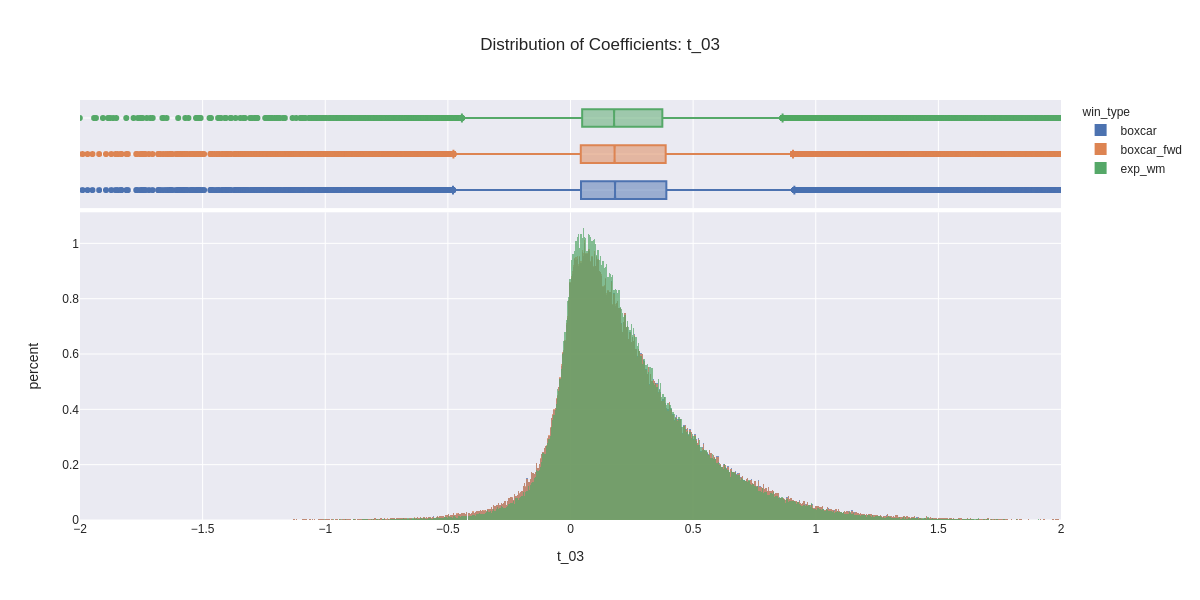

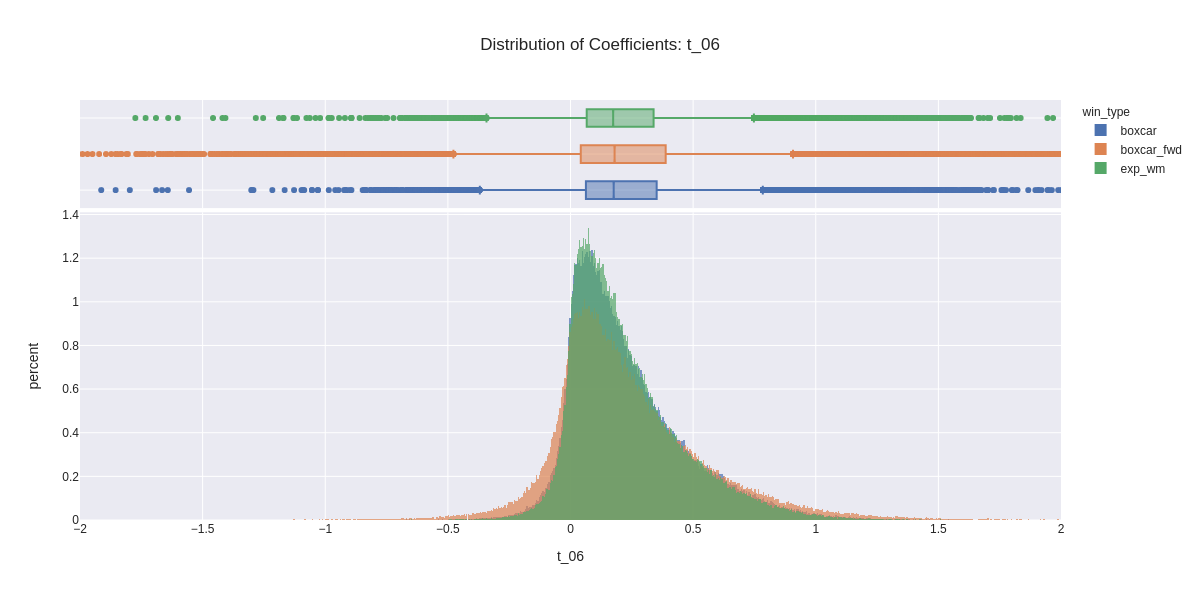

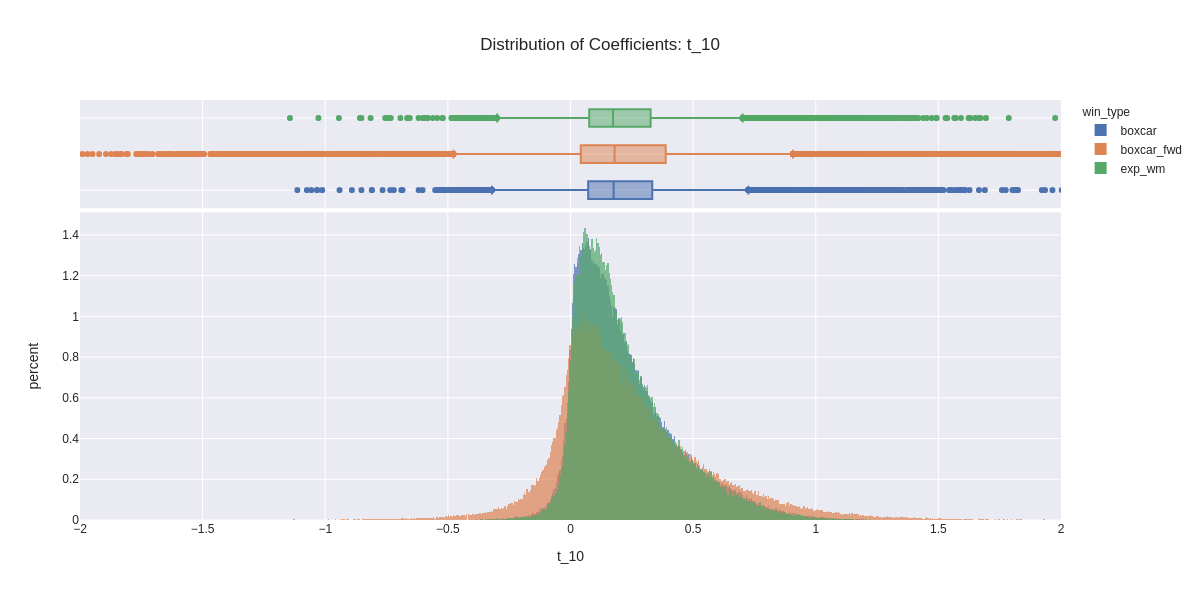

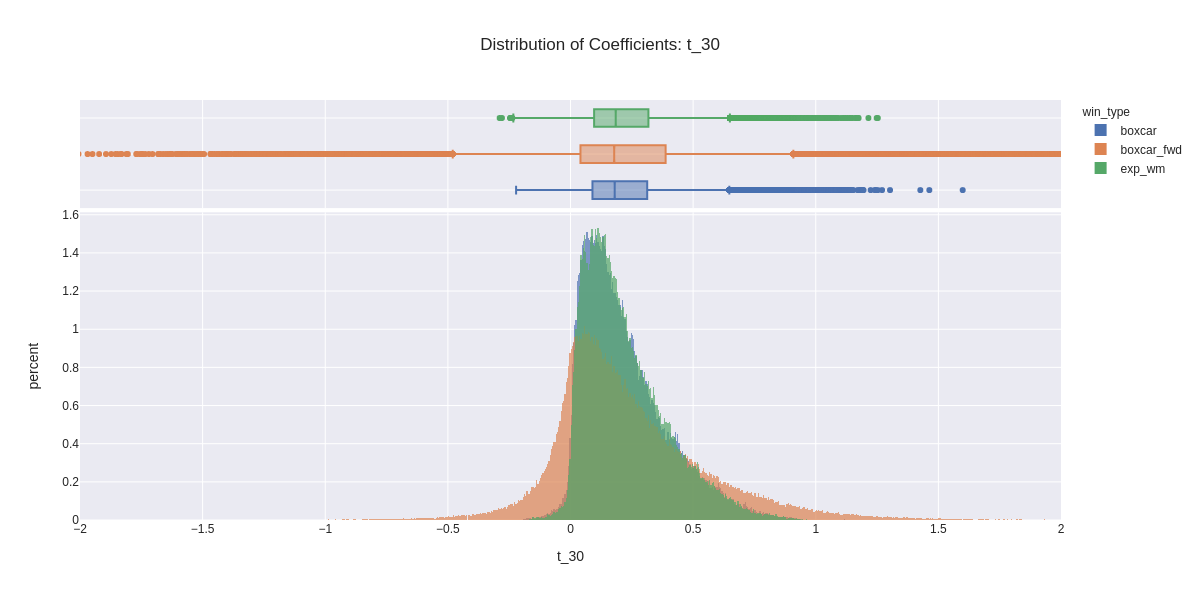

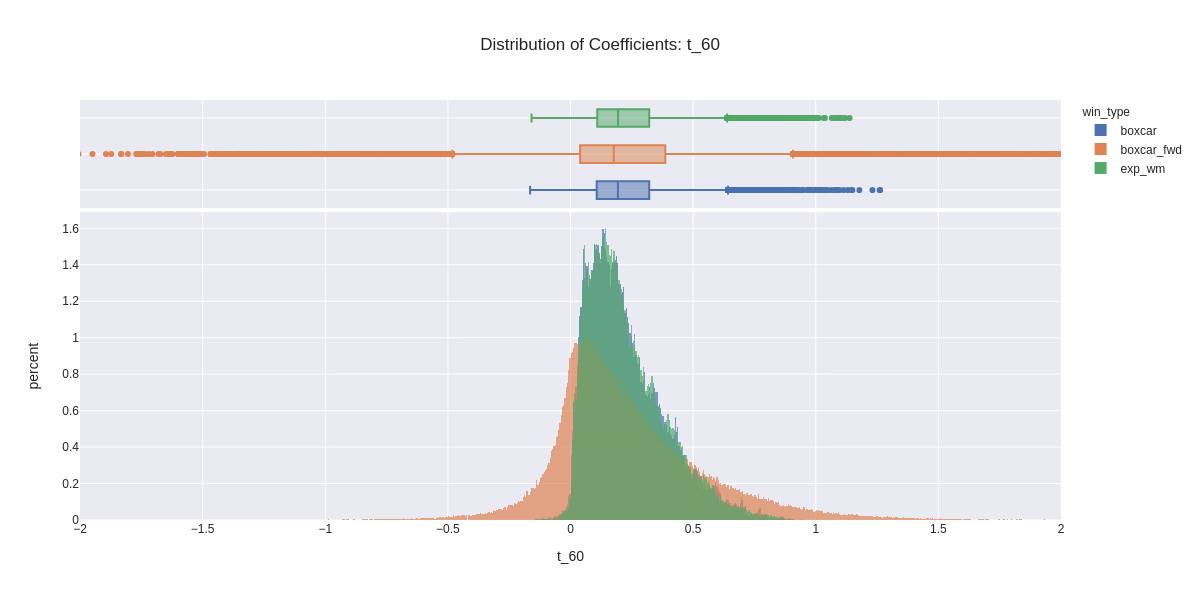

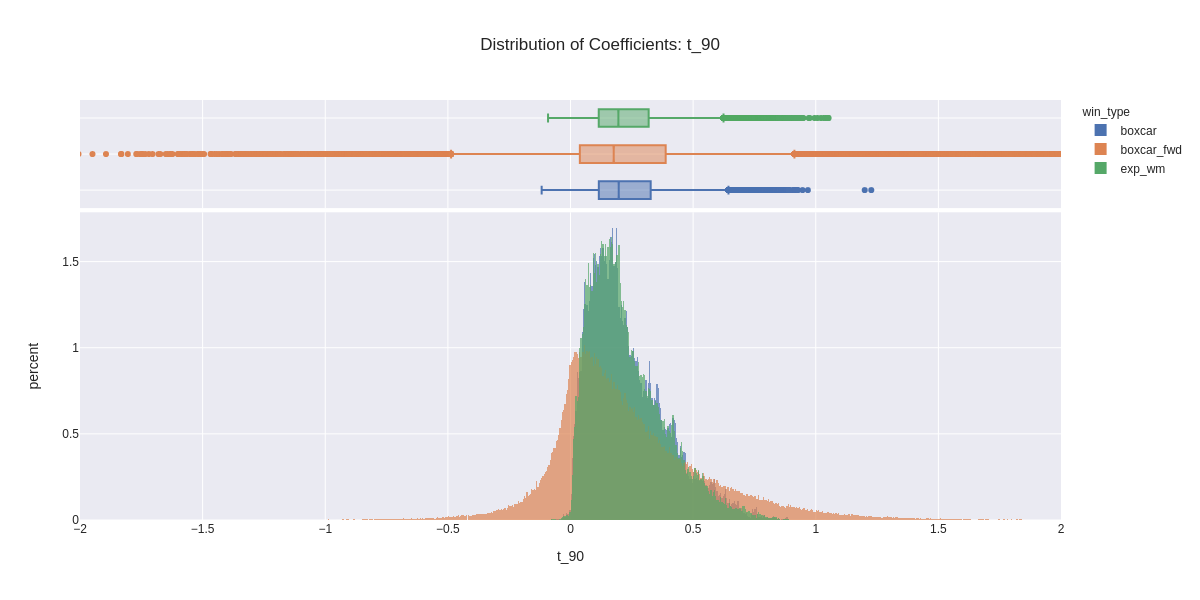

In [12]:
utils.show_histograms(df_betas.loc["2016-02-01":])

### Compare Correlations

Lastly, we analyze correlation between the series of coefficients. If we were concerned with matching the series of coefficients, i.e., the ewm and boxcar series for a particular window length to the next forward boxcar window, the merely analyzing the distributions would be insufficient since the distributions do not take order into account. As a case in point, the distributions of the forward boxcar window and rearward looking boxcar window of 6 observations are nearly identical, yet when we look at the correlation below, we see that they are the least correlated. The highest correlation was actually with the exponentially weighted window of 30 days with a correlation of 0.326.

In [13]:
df_cor = df_betas.loc["2016-02-01":].swaplevel("stat", "win_type", axis=1).beta_1
corrs = []
for win_type in ["boxcar", "exp_wm"]:
    for win_len in df_cor.columns.levels[1]:
        corrs.append((f"{win_type}_{win_len}", df_cor[("boxcar_fwd", "t_03")].corr(df_cor[(win_type, win_len)].dropna())))
df_cor = pd.DataFrame(corrs)
df_cor.columns = ["win_type_len", "correlation"]
df_cor
utils.px.bar(df_cor, x="win_type_len", y="correlation", title="Correlation")